# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl

In [2]:
import scipy.cluster.hierarchy
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils_iads as ut

## Chargement des données (base MovieLens + enrichissements)

In [3]:
# Chargement des données MovieLens
fname_links = "./data/links.csv"
fname_movies = "./data/movies.csv"
fname_ratings = "./data/ratings.csv"
fname_tags = "./data/tags.csv"

links = pd.read_csv(fname_links, encoding='utf8')
movies = pd.read_csv(fname_movies, encoding='utf8')
ratings = pd.read_csv(fname_ratings, encoding='utf8')
tags = pd.read_csv(fname_tags, encoding='utf8')

In [4]:
# Chargement des données complémentaires
fname_act = "./data/act_v2.pkl"
fname_film = "./data/film_v2.pkl"
fname_crew = "./data/crew_v2.pkl"

acteurs = pkl.load(open(fname_act, "rb"))
films = pkl.load(open(fname_film, "rb"))
crews = pkl.load(open(fname_crew, "rb"))

In [5]:
# Chargement de la base kaggle (facultative)
fname_k_movies = "./data/k_movies.csv"

k_movies = pd.read_csv(fname_k_movies, encoding='cp1252')

# Q1 - Mise en forme des données

<font color='0x199730'> Elimination des films de MovieLens qui ne sont pas dans la base films.<br/>
    Définition d'un dictionnaire 'liste_genres' avec pour clé un genre et pour valeur son nombre d'occurences dans movies.<br/>
    Définition d'outils pour naviguer d'un movieId vers un tmdbId et vice versa.<br/>
    Compter le nombre de films joués par un acteur.<br/>
    Identification des catégories d'un film selon son titre.<br/>
    Identification des genres des film et leur occurence où un acteur a joué.<br/>
</font>

In [6]:
#on recupere tous les tmdbId connus de la base film
tmdbIds = []
for f in films:
    tmdbIds.append(float(f['id']))

#pour chaque link, si le tmdbId n'est pas dans tmdbIds
#se souvenir du l'imdbId
movieIdsToDel = []
for i in range(len(links)):
    if float(links.iloc[i,2]) not in tmdbIds:
        movieIdsToDel.append(links.iloc[i,0])

#supprimer la ligne de l'imdbId dans les bases de MovieLens
for i in movieIdsToDel:
    links = links[links.movieId != i]
    movies = movies[movies.movieId != i]
    ratings = ratings[ratings.movieId != i]
    tags = tags[tags.movieId != i]

In [7]:
liste_genres = dict()
for string in (list(movies['genres'])):
    for g in string.split("|"):
        if g not in liste_genres.keys():
            liste_genres[g] = 1
        else:
            liste_genres[g] += 1

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [8]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in acteurs:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# fonction de traduction des indexs tmdb vers imdb et vice versa
def movieToTmdb(movieId):   
    tmp = links[links.movieId==movieId]
    tmp = tmp['tmdbId']
    return float(tmp)

def tmdbToMovie(tmdbId):
    tmp = links[links.tmdbId==tmdbId]
    tmp = tmp['movieId']
    return int(tmp)

In [9]:
# Compte le nombre de films dans lesquels joue l'acteur
def countFilmOfActor(actor):
    nb = 0
    for lista in acteurs:
        for a in lista:
            if (a['name'] == actor):
                nb+=1
    return nb

#Catégories d'un film en fonction de son titre
def categoriesByTitleOfMovie(title):
    for f in films:
        if f['title']==title:
            tmdb_id = float(f['id'])
            movie_id = tmdbToMovie(tmdb_id)
            movie = movies[movies.movieId==movie_id]
            return (list(movie['genres'])[0].split('|'))

#dictionnaire des genre:occurences où l'acteur a joué
def GenresByActor(actor):
    res = dict()
    fid = []
    i = 0
    #on cherche tous les id des films (fid) dans lesquels l'acteur joue
    for lista in acteurs:
        find = False
        for a in lista:
            if a['name']==actor:
                find = True
                break
        if find:
            fid.append(i)
        i+=1
    #pour chaque id, on va recupérérer son titre dans films, puis faire les join dans link
    for i in fid:
        film = films[i]
        tmdbId = float(film['id'])
        l = links[links.tmdbId==tmdbId]
        movieId = (l['movieId'])
        #si len == 0 alors il y a un tmdbId qui n'a pas de traduction movieId dans links
        if len(movieId.values) != 0:
            m = movies[movies.movieId == int(movieId)]
            g = m['genres'].values
            g = g[0].split('|')
            for k in g:
                if k in res.keys():
                    res[k] += 1.0
                else:
                    res[k] = 1.0
    return res


assert countFilmOfActor('Tom Hanks')==57
assert movieToTmdb(tmdbToMovie(862.0))==862.0
assert tmdbToMovie(movieToTmdb(1))==1
assert categoriesByTitleOfMovie('Waiting to Exhale')==['Comedy','Drama','Romance']

# Q2 - Régression supervisé

<font color='0x199730'>prédiction de la note moyenne donnée à un film par les internautes</font>

In [10]:
k_genres = np.unique(k_movies['genre'])

In [11]:
def accuracy(LSet,Class):
    somme=0
    for i in range(LSet.size()):
        somme += (Class.predict(LSet.getX(i))-LSet.getY(i)[0])**2
    return somme/LSet.size()


#on garde les colonnes que l'on veut traiter
question2_base = k_movies.loc[:,["score", "genre", "budget", "runtime"]]
#on supprime les lignes où le budget = 0
question2_base = question2_base[question2_base.budget > 0]

#on crée des attributs(colonnes) et on normalise
moyenne_budget = question2_base['budget'].mean()
ecarttype_budget = question2_base['budget'].std()
question2_base['budgetNormalise'] = (question2_base['budget']-moyenne_budget)/ecarttype_budget

moyenne_runtime = question2_base['runtime'].mean()
ecarttype_runtime = question2_base['runtime'].std()
question2_base['runtimeNormalise'] = (question2_base['runtime']-moyenne_runtime)/ecarttype_runtime 

for g in k_genres:
    question2_base[g] = (question2_base['genre']==g).astype(int)


del question2_base['genre']
del question2_base['budget']
del question2_base['runtime']


#le nombre de dimension de notre problème
dimension = len(question2_base.columns)-1

#On initialise le labelset
the_set_q2 = ls.LabeledSet(dimension)
for row in question2_base.itertuples():
    the_set_q2.addExample(row[2:], row[1])

#on le split
train_q2, test_q2 = the_set_q2.split(0.8)

question2_base.head()

,score,budgetNormalise,runtimeNormalise,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,8.1,-0.704177,-1.031778,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.8,-0.754216,-0.254984,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6.9,-0.529044,0.133414,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8.4,-0.441477,1.631517,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.9,-0.679158,-0.976292,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
import math
import seaborn as sns  # for making plots with seaborn


def getNthDict(df, n):
      return df[n:n + 1].to_dict(orient='records')[0]


def viewData(data, vx=0, vy=0, kde=True, title=True, axes=True):
    x = 4
    y = 4
    
    nbCol = 4
    nbRow = math.ceil(len(data.keys())/x)
    plt.figure(figsize=(x*nbCol+x, y*nbRow+y))
    
    for i, k in enumerate(data.keys()):
        
        ax = plt.subplot(x+vx, y+vy, i+1)
        if(title):
            ax.set_title("Distribution of '{0}': {1} in [{2},{3}]".format(
            k, len(data[k].unique()), data[k].min()//1, data[k].max()//1))
        
        ax = sns.distplot(data[k], kde=kde)
        
        if not axes:
            ax.set_xlabel("")

C:\Users\Vincent\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,score,budget,runtime
count,4638.000000,4.638000e+03,4638.000000
mean,6.356317,3.614560e+07,107.595515
std,1.011063,3.996947e+07,18.022792
min,1.500000,6.000000e+03,69.000000
25%,5.800000,1.000000e+07,96.000000
50%,6.400000,2.300000e+07,104.000000
75%,7.100000,4.600000e+07,117.000000
max,9.300000,3.000000e+08,280.000000


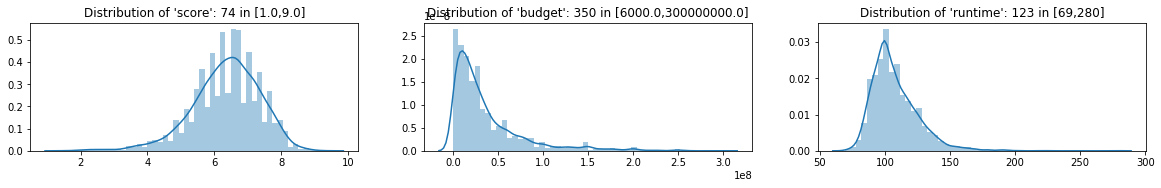

In [13]:
tmpStats = (k_movies.loc[:,['score','budget','runtime']])
tmpStats = tmpStats[tmpStats.budget > 0]
viewData(tmpStats, vx=-1, vy=-1, axes=False)
tmpStats.describe()

In [14]:
class ClassifierKNN(cl.ClassifierKNN):
    """ Classe pour représenter un classifieur par K plus proches voisins.
        Cette classe hérite de la classe Classifier
    """
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        def dist(u,v):
            dist = (u-v)**2
            dist = sum(dist)
            return dist

        d = np.array([dist(x,self.labeledSet.getX(i)) for i in range(self.labeledSet.size())])
        dSort=np.argsort(d)
        value = 0
        
        for i in range(self.k):
            value += self.labeledSet.getY(dSort[i])

        return value/self.k

knn = ClassifierKNN(dimension, 3)
knn.train(train_q2)
acc = 0
for i in range(test.size()):
    acc += abs(test.getY(i)[0] - knn.predict(test_q2.getX(i))[0])
print("accuracy",accuracy(test_q2,knn)[0])

# Q3 - Classification supervisé
<font color='0x199730'>prédiction de la catégorie d'un film</font>

# Q4 - Utilisation de données catégorielles
<font color='0x199730'>(catégories, acteurs,...) de manière discrète ET de manière continue (dummy coding) dans des approches différentes</font>

# Q5 - Catégorisation non supervisée des acteurs

<font color='0x199730'>Nous allons utiliser la méthode de clustering vue en cours.<br/>
Nous appliquerons l'algorithme de clustering_hierarchique en utilisant l'approche "complete linkage"</font>

In [ ]:
def normalisation_Dictionnaire(dico):
    dicoRes = dict()
    maxi = max(dico.values())
    for k,v in dico.items():
        dicoRes[k] = (v / maxi)
    return dicoRes

In [ ]:
nbFilmMin = 20
adict = dict()

for i in range(len(acteurs)):
    lista = acteurs[i]
    if len(lista)==0:
        continue
    film = films[i]
    if film['vote_count']<5000:
        continue
    star = lista[0]
    aname = star['name']
    if (aname not in adict.keys()):
        nb = countFilmOfActor(aname)
        if nb >= nbFilmMin:
            adict[aname] = nb

In [ ]:
data_Acteurs = pd.DataFrame()
for a in adict.keys():
    dicoa = normalisation_Dictionnaire(GenresByActor(a))
    for k,v in dicoa.items():
        data_Acteurs.at[a, k] = v
data_Acteurs = data_Acteurs.fillna(0)

In [ ]:
data_Acteurs.head()

In [ ]:
liste_genres

In [ ]:
viewData(data_Acteurs, vx=3, vy=1, title=False)

In [ ]:
def dist_euclidienne_vect(v1, v2):
    somme = 0
    for i in range(len(v1)):
        somme += (v2[i]-v1[i])**2
    return np.sqrt(somme)

def dist_manhattan_vect(v1, v2):
    somme = 0
    for i in range(len(v1)):
        somme += abs(v2[i]-v1[i])
    return somme

def dist_vect(s, v1, v2):
    if s=='manhattan':
        return dist_manhattan_vect(v1, v2)
    elif s=='euclidienne':
        return dist_euclidienne_vect(v1, v2)

def initialise(M):
    res=dict()
    for i in range(len(M)):
        res[i]=np.array([M[i]])
    return res

def dist_max_groupes(nom, M0, M1):
    distmax=-1
    for v in M0:
        for v2 in M1:
            dist = dist_vect(nom, v, v2)
            if dist > distmax:
                distmax = dist
    return distmax

def fusionne(nom, C0):
    distmin=sys.maxsize
    mink1=0
    mink2=1
    maxk=-1
    for k,v in C0.items():
        for k2,v2 in C0.items():
            if k==k2:
                continue
            dist = dist_max_groupes(nom, v, v2)
            if dist < distmin:
                distmin = dist
                mink1=k
                mink2=k2
        if k > maxk:
            maxk=k
    C1 = dict()
    for k,v in C0.items():
        if k!=mink1 and k!=mink2:
            C1[k] = C0[k]
    C1[maxk+1] = np.concatenate((C0[mink1], C0[mink2]),axis=0)
    return C1,mink1,mink2,distmin

def clustering_hierachique(df, nom):
    M_data2D=df.as_matrix()
    courant = initialise(M_data2D)       # clustering courant, au départ:s données data_2D normalisées
    M_Fusion = []                        # initialisation
    while len(courant) >=2:              # tant qu'il y a 2 groupes à fusionner
        new,k1,k2,dist_min = fusionne(nom,courant)
        if(len(M_Fusion)==0):
            M_Fusion = [k1,k2,dist_min,2]
        else:
            M_Fusion = np.vstack( [M_Fusion,[k1,k2,dist_min,2] ])
        courant = new
        
    plt.figure(figsize=(30, 15)) # taille : largeur x hauteur
    plt.title('Dendrogramme', fontsize=25)    
    plt.xlabel('Acteurs', fontsize=25)
    plt.ylabel('Distance', fontsize=25)

    seuil = 27
    def printDistance():
        for i, d, c in zip(dendogramme['icoord'], dendogramme['dcoord'], dendogramme['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > dendogramme.pop('annotate_above', 0):
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        plt.axhline(y=seuil, c='k')
    
    # Construction du dendrogramme à partir de la matrice M_Fusion:
    dendogramme = scipy.cluster.hierarchy.dendrogram(
        M_Fusion,
        leaf_font_size=10.,  # taille des caractères de l'axe des X
        #color_threshold=seuil,
        labels = data_Acteurs.index.values,
    )
    
    # Affichage du résultat obtenu:
    plt.show()
    
    return M_Fusion

In [ ]:
fus = clustering_hierachique(data_Acteurs,"euclidienne")

# Q5.2 - Catégorisation non supervisée des utilisateurs

<br>
<font color="green">
    Le but ici est de regrouper les utilisateurs afin d'avoir des profils d'utilisateurs pour ensuite pouvoir, par exemple, faire des recommandations sur un film. On utilisera l'algorithme des K-moyennes.
</font>

In [8]:
def normalisation(df):
    return (df-df.min())/(df.max()-df.min())

def dist_vect(s1, s2):
    #tmp=~s1.isnull() & ~s2.isnull() #rectifie si une valeur est NaN
    return np.sqrt(((s1-s2)**2).sum())
    
def centroide(df):
    return df.mean().to_frame().T

def inertie_cluster(df):
    c=centroide(df)
    somme=0
    for i in range(len(df)):
        serie = df.iloc[i]
        somme += dist_vect(serie, c.iloc[0])**2
    return somme
    
def initialisation(k, df):
    return df.iloc[random.sample([i for i in range(len(df))],k)]

def plus_proche(e, df):
    imin = 0
    dmin = dist_vect(e,df.iloc[0])
    for i in range(1, len(df)):
        d = dist_vect(e, df.iloc[i])
        if d<dmin:
            dmin=d
            imin=i
    return imin

def affecte_cluster(df,centroides):
    res=dict()
    for i in range(len(df)):
        proche = plus_proche(df.iloc[i],centroides)
        if (proche not in res):
            res[proche]=[i]
        else : 
            res[proche].append(i)
    return res

def inertie_globale(df, mat):
    return sum([inertie_cluster(df.iloc[v]) for k,v in mat.items()])

def nouveaux_centroides(df, mat):
    res = pd.DataFrame()
    for k,v in mat.items():
        res = res.append(centroide(df.iloc[v]), ignore_index=True)
    return res
    
def kmoyennes(k, df, epsilon, iter_max):
    centroides = initialisation(k, df)
    mat = affecte_cluster(df, centroides)
    
    centroides = nouveaux_centroides(df, mat)
    inertie = inertie_globale(df, mat)
    
    for i in range(iter_max):
        mat = affecte_cluster(df, centroides)
        centroides = nouveaux_centroides(df, mat)
        new_inertie = inertie_globale(df, mat)
        if (abs(inertie-new_inertie) < epsilon):
            break
        inertie = new_inertie
    
    return centroides,mat

In [9]:
s1=pd.Series([1,2,np.NaN,4])
s2=pd.Series([4,2,3,1])
dist_vect(s1,s2)

4.242640687119285

<font color="green">critère ? cb de films de tel genre a t'il regardé ? moyenne par genre ? les deux ?</font>

In [10]:
tmp = movies[["movieId","genres"]]
tmp.head()

,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy


In [11]:
genres=[]
for i in range(len(tmp)):
    for genre in tmp.iloc[i,1].split("|"):
        if genre not in genres:
            genres.append(genre)
print(len(genres), genres)

20 ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)']


In [12]:
for g in genres :
    tmp[g]=0

for i in tmp.index:
    l=tmp.loc[i,"genres"].split('|')
    for g in genres:
        if(g in l):
            tmp.loc[i,g]=1

In [13]:
tmp=tmp.drop(columns=["genres"])

In [14]:
tmp.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
tmp=ratings.join(tmp.set_index('movieId'), on="movieId").drop(columns=["timestamp","movieId"])

In [16]:
#calcul moyenne donnée à un genre
userIds=np.unique(tmp['userId'])
res=[]
for id in userIds:
    ligne=[id]
    for g in genres:
        ligne.append(tmp.loc[(tmp["userId"]==id) & (tmp[g]==1),"rating"].mean())
    res.append(ligne)

In [17]:
profils=pd.DataFrame(res, columns=['userId']+genres)

In [18]:
profils=profils.set_index('userId')

In [19]:
profils.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
userId,,,,,,,,,,,,,,,,,,,,
1,4.388235,4.689655,4.547619,4.277108,4.297872,4.307692,4.529412,4.322222,4.355556,4.145455,3.470588,4.166667,4.225000,4.500000,4.681818,NaN,NaN,4.285714,5.0,NaN
2,3.750000,NaN,NaN,4.000000,NaN,4.500000,3.906250,3.850000,3.800000,3.562500,3.000000,4.000000,3.500000,4.500000,NaN,4.0,3.750000,3.500000,NaN,NaN
3,2.722222,0.500000,0.500000,1.062500,3.375000,0.500000,0.750000,3.571429,0.500000,4.000000,4.687500,5.000000,4.142857,0.500000,0.500000,NaN,NaN,NaN,NaN,NaN
4,3.655172,4.000000,3.800000,3.509615,3.684211,3.379310,3.483333,3.320000,3.814815,3.552632,4.250000,3.478261,2.833333,3.571429,4.000000,4.0,3.000000,3.800000,4.0,NaN
5,3.250000,4.333333,4.111111,3.466667,4.142857,3.090909,3.800000,3.111111,3.833333,3.555556,3.000000,4.000000,2.500000,3.333333,4.400000,NaN,3.666667,3.000000,NaN,NaN


quand NaN alors dans le calcul d'inertie ajouter 0

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


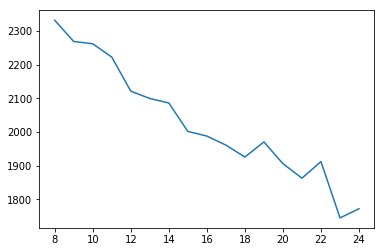

In [113]:
res=[]
for k in range(8,25):
    print(k)
    cent, mat= kmoyennes(k, profils, 10, 100)
    res.append(inertie_globale(df=profils,mat=mat))
plt.plot([k for k in range(8,25)],res)
plt.show()

In [20]:
cent, mat= kmoyennes(18, profils, 10, 100)
print(inertie_globale(df=profils,mat=mat))
mat

1911.631471664819


{0: [0,
  24,
  29,
  42,
  45,
  51,
  52,
  68,
  92,
  96,
  105,
  121,
  127,
  153,
  167,
  170,
  187,
  208,
  235,
  245,
  250,
  257,
  275,
  290,
  295,
  318,
  347,
  370,
  388,
  399,
  412,
  416,
  440,
  451,
  458,
  474,
  490,
  514,
  518,
  522,
  532,
  537,
  542,
  580,
  583,
  585,
  594,
  600],
 1: [1,
  5,
  39,
  57,
  70,
  99,
  125,
  183,
  200,
  223,
  259,
  277,
  294,
  309,
  343,
  365,
  381,
  392,
  425,
  475,
  512,
  520,
  535,
  541,
  554,
  577,
  591,
  593],
 2: [2, 35, 54, 75, 77, 80, 229, 254, 310, 364],
 3: [3,
  32,
  97,
  102,
  141,
  143,
  144,
  151,
  171,
  186,
  199,
  220,
  247,
  268,
  283,
  285,
  329,
  338,
  340,
  348,
  382,
  389,
  398,
  423,
  433,
  439,
  443,
  450,
  496,
  511,
  519,
  533,
  550,
  567,
  573],
 4: [4,
  8,
  15,
  17,
  23,
  26,
  31,
  41,
  50,
  56,
  59,
  62,
  63,
  83,
  88,
  100,
  101,
  109,
  114,
  116,
  117,
  133,
  134,
  139,
  140,
  147,
  150,
  155,
  1

In [24]:
profils.iloc[mat[3]]

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
userId,,,,,,,,,,,,,,,,,,,,
4,3.655172,4.000000,3.800000,3.509615,3.684211,3.379310,3.483333,3.320000,3.814815,3.552632,4.250000,3.478261,2.833333,3.571429,4.000000,4.000000,3.000000,3.800000,4.000000,NaN
33,3.900000,3.833333,3.875000,3.827586,3.500000,3.854545,3.791304,4.000000,3.923077,3.633333,4.500000,3.666667,4.142857,4.125000,4.000000,NaN,3.000000,4.000000,5.000000,NaN
98,3.400000,4.029412,3.882353,4.048387,3.500000,3.875000,3.909091,3.350000,4.250000,3.866667,4.250000,4.600000,3.312500,4.666667,3.750000,NaN,3.291667,NaN,NaN,NaN
103,3.518868,3.660377,3.660920,3.824675,3.657143,3.836364,4.164671,3.706250,4.388889,4.041667,3.642857,3.960000,3.529412,4.166667,3.870370,3.500000,3.172414,4.437500,4.750000,NaN
142,3.777778,4.333333,4.250000,4.111111,4.000000,4.000000,3.888889,3.307692,3.888889,3.736842,5.000000,4.500000,3.000000,4.666667,4.333333,NaN,4.333333,4.000000,NaN,NaN
144,3.666667,4.076923,3.823529,3.463636,3.777778,3.712500,3.798077,3.418919,3.710526,3.483871,3.916667,4.000000,3.000000,3.666667,4.375000,3.500000,3.833333,3.625000,NaN,NaN
145,3.272727,4.333333,4.333333,3.375000,4.500000,3.333333,3.444444,2.875000,3.571429,3.555556,NaN,5.000000,2.750000,4.000000,4.000000,NaN,3.500000,4.000000,NaN,NaN
152,3.500000,4.500000,4.500000,3.750000,3.166667,4.000000,4.037500,3.588235,4.136364,4.020833,4.500000,4.062500,3.500000,4.333333,3.500000,4.375000,3.500000,NaN,4.000000,NaN
172,3.750000,3.500000,3.750000,4.000000,3.900000,5.000000,3.833333,3.700000,3.833333,3.700000,3.750000,4.500000,3.875000,3.666667,3.500000,NaN,NaN,3.500000,NaN,NaN


# Q6 - Expérience:  Comparaison des performances d'un classifieur Gradient Stochastique en fonction de son taux d'apprentissage 

<font color='0x199730'>Nous allons utiliser un classifieur Gradient Stochastique et faire varier son taux d'apprentissage (learning_rate) jusqu'à trouver la valeur la plus intéressante pour résoudre le problème.<br/></font>

In [ ]:
dim = the_set_q2.getInputDimension()
train_q6_1, test_q6_1 = the_set_q2.split(0.01)
train_q6_2, test_q6_2 = train_q6_1.split(0.8)
print(train_q6_1.size())
print(test_q6_2.size())

N = 100
for epsilon in [1/(10**n) for n in range(1, 5)]:
    perceptron = cl.ClassifierPerceptron(dim, epsilon)
    accuracies=[]
    for i in range (N):
        perceptron.train(train_q6_1)
        acc = accuracy(test_q6_2, perceptron)
        accuracies.append(acc)
    print("epsilon =",epsilon)
    plt.plot(accuracies)
    plt.show()

on cherche à minimiser le plus possible l'accuracy (qui représente ici la distance entre la note réelle du film et la note estimée)<br/>
on va donc exploiter la fenetre entre 0.0001 à 0.001

In [ ]:
N = 100
for epsilon in [0.0001*i for i in range(1,11)]:
    perceptron = cl.ClassifierPerceptron(dim, epsilon)
    accuracies=[]
    for i in range (N):
        perceptron.train(train_q6_1)
        acc = accuracy(test_q6_2, perceptron)
        accuracies.append(acc)
    print("epsilon =",epsilon)
    plt.plot(accuracies)
    plt.show()